# **필요한 파일 Import**

In [1]:
import os
import random
import urllib.request
import tarfile
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

**1. 데이터 셋을 불러오기 위한 코드**

download_and_extract_data : 위치에서 data를 불러온 후 tar 파일을 압축해제 한 뒤 DATA_DIR 경로에 저장

OxfordPetsDataset : torch 공식문서의 data class를 구현

In [2]:
def download_and_extract_data(url, DATA_DIR, file_name):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    tar_path = os.path.join(DATA_DIR, file_name)

    if not os.path.exists(tar_path):
        print(f"Downloading {file_name}...")
        urllib.request.urlretrieve(url, tar_path)
        print(f"Download of {file_name} complete.")

    print(f"Extracting {file_name}...")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=DATA_DIR)
    print(f"Extraction of {file_name} complete.")

In [3]:
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, labels_file, split="train", transform=None):
        self.images_dir = images_dir
        self.split = split
        self.transform = transform
        self.image_paths, self.labels = self.load_annotations(labels_file)

    def load_annotations(self, labels_file):
        with open(labels_file, "r") as f:
            lines = f.readlines()

        image_paths = []
        labels = []
        for line in lines:
            parts = line.strip().split(" ")
            image_paths.append(parts[0] + ".jpg")
            labels.append(int(parts[1]) - 1)

        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

#Dataset 분석
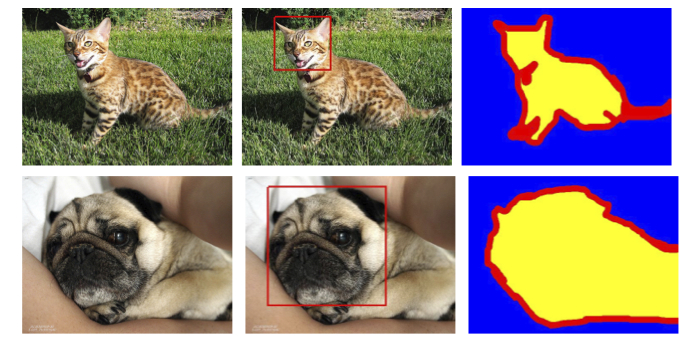

# Oxford Pets Dataset

Oxford Pets Dataset은 Oxford 대학의 Visual Geometry Group(VGG)에서 제공하는 이미지 데이터셋으로, 주로 반려동물 이미지 분류 및 객체 인식 연구에 사용됩니다.

## 주요 특징

- **목표**: 이미지 분류와 객체 탐지를 위한 데이터셋입니다.
- **구성**: 총 **7,349개의 이미지**가 포함되어 있으며, **37개의 개와 고양이 품종**에 대한 이미지입니다.
- **파일 형식**: 이미지 파일은 **JPG** 형식이며, 각 이미지에 대한 라벨 정보는 **.txt** 파일로 제공됩니다.

## 용도

- **이미지 분류**: 다양한 개와 고양이 품종을 분류하는 데 사용됩니다.
- **객체 탐지**: 동물 품종을 인식하는 작업에 활용됩니다.
- **세분화 (Segmentation)**: 이미지 내에서 반려동물을 정확히 분할하는 작업에 사용될 수 있습니다.

## 데이터셋 크기

**7,349개의 이미지**는 중소형 규모의 데이터셋에 해당합니다. 데이터셋 크기에 따라, 특히 더 복잡한 모델을 학습시킬 때 **더 많은 이미지**가 필요할 수 있습니다. 따라서, 이 데이터셋은 제한된 품종 분류를 위한 모델 학습에 적합할 수 있지만, **대규모 모델 훈련**이나 **세밀한 품종 구분**에는 추가적인 데이터가 필요할 수 있습니다.



In [4]:
#dataset을 만드는데 사용할 경로들 모음
DATA_URL = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
ANNOTATIONS_URL = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
DATA_DIR = "./oxford_pets_data"
images_dir = os.path.join(DATA_DIR, "images")
annotations_file = os.path.join(DATA_DIR, "annotations/trainval.txt")
test_annotations_file = os.path.join(DATA_DIR, "annotations/test.txt")

In [5]:
download_and_extract_data(DATA_URL, DATA_DIR, "images.tar.gz")
download_and_extract_data(ANNOTATIONS_URL, DATA_DIR, "annotations.tar.gz")

Extracting images.tar.gz...
Extraction of images.tar.gz complete.
Extracting annotations.tar.gz...
Extraction of annotations.tar.gz complete.


In [6]:
# 데이터 경로 확인
if not os.path.exists(images_dir):
    raise FileNotFoundError(f"Images directory does not exist: {images_dir}")
if not os.path.exists(annotations_file):
    raise FileNotFoundError(f"Annotations file does not exist: {annotations_file}")

# Transform 정의 반드시 Normalize 전에 ToTensor() 가 불러져야 함
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 생성
dataset = OxfordPetsDataset(images_dir, annotations_file, transform=train_transform)
# print(full_dataset[1])


# 학습/검증 데이터셋 랜덤 분할 단순히 index 기준으로 자르면, 특정 class에 치중될 것 같음.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = OxfordPetsDataset(images_dir, test_annotations_file, transform=test_transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
# print(train_dataset[1])

Train Dataset Size: 3312
Validation Dataset Size: 368
Test Dataset Size: 3669


**2. 모델 생성**

모델의 요구조건은 skip connection, batch norm, dropout을 포함해야 한다.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=37):
        super(CustomCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)

        # Block 4
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(512)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn10 = nn.BatchNorm2d(512)

        # Adaptive pooling to handle input size variations
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(512, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x))) + x
        x = F.max_pool2d(x, 2)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x))) + x
        x = F.max_pool2d(x, 2)

        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x))) + x
        x = F.max_pool2d(x, 2)

        # Block 4
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x))) + x
        x = F.max_pool2d(x, 2)

        # Global Average Pooling
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


앞 선 모델의 크기가 너무 작다고 판단되어 residual block 의 갯수를 조절해 모델 사이즈를 크고 작게 조절할 수 있도록 구성했다.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, block, layers, num_classes=37):
        super(CustomResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [9]:
def custom_resnet18(num_classes=37):
    return CustomResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

model = custom_resnet18(num_classes=37)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

**loss curve 시각화**

In [10]:
def visualize_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

**train_step**

In [11]:
def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    total_train_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_accuracy = 100 * total_correct / total_samples
    return avg_train_loss, train_accuracy

**valid_step**

In [12]:
def validate_step(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_accuracy = 100 * total_correct / total_samples
    return avg_val_loss, val_accuracy

**train_model**

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device="cpu"):
    model.to(device)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        avg_train_loss, train_accuracy = train_step(model, train_loader, criterion, optimizer, device)
        train_loss_history.append(avg_train_loss)

        avg_val_loss, val_accuracy = validate_step(model, val_loader, criterion, device)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%")

    return train_loss_history, val_loss_history

**test model**

In [14]:
def test_model(model, test_loader, criterion, device="cpu"):
    model.to(device)
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100 * correct / total

    print("\nTest Results")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%\n")

    return test_loss, test_acc

Epoch 1/30
Train Loss: 3.5445, Train Accuracy: 6.6425%
Validation Loss: 3.4960, Validation Accuracy: 7.8804%
Epoch 2/30
Train Loss: 3.2530, Train Accuracy: 10.6280%
Validation Loss: 3.2329, Validation Accuracy: 12.5000%
Epoch 3/30
Train Loss: 3.1011, Train Accuracy: 14.2512%
Validation Loss: 3.0748, Validation Accuracy: 16.8478%
Epoch 4/30
Train Loss: 2.9568, Train Accuracy: 17.4215%
Validation Loss: 3.0134, Validation Accuracy: 17.1196%
Epoch 5/30
Train Loss: 2.7845, Train Accuracy: 21.8297%
Validation Loss: 3.0407, Validation Accuracy: 19.2935%
Epoch 6/30
Train Loss: 2.6623, Train Accuracy: 24.6679%
Validation Loss: 2.9427, Validation Accuracy: 20.1087%
Epoch 7/30
Train Loss: 2.4645, Train Accuracy: 29.3478%
Validation Loss: 2.9185, Validation Accuracy: 17.9348%
Epoch 8/30
Train Loss: 2.2856, Train Accuracy: 33.1824%
Validation Loss: 2.8366, Validation Accuracy: 25.2717%
Epoch 9/30
Train Loss: 2.1259, Train Accuracy: 37.1679%
Validation Loss: 2.8383, Validation Accuracy: 20.3804%
Epo

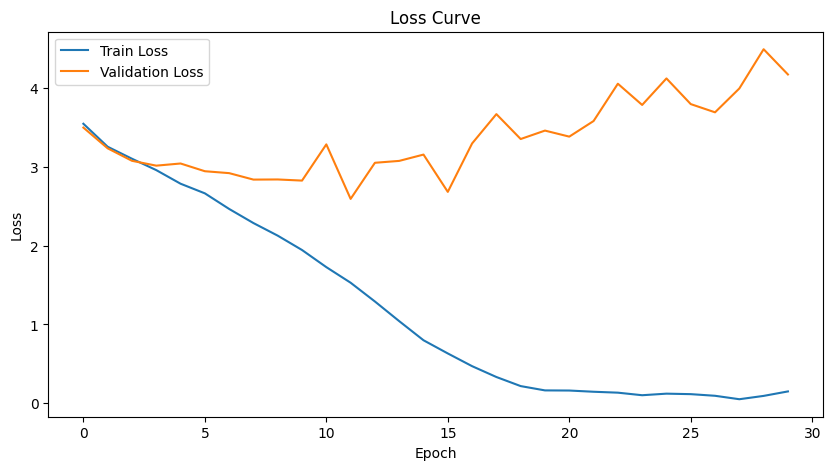

In [15]:
from PIL import Image

# 학습 및 검증 실행
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 30

# 학습 시작
train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

# 학습 손실 그래프 출력
visualize_loss(train_loss, val_loss)

In [16]:
test_model(model = model, test_loader = test_loader, criterion = criterion, device=device)


Test Results
Test Loss: 4.3122
Test Accuracy: 27.01%



(4.312194227814902, 27.01008449168711)

# 분석 및 고찰

**성능이 낮게 나온 이유**

매우 낮은 해상도를 가지는 MNIST조차 70000개의 데이터를 가지는데, 이 데이터셋은 그보다 훨씬 높은 해상도를 가지면서, 적은 데이터 수를 요구하기 때문에 학습이 쉽지 않을 것이라 예상했고, 실제로 성능이 잘 나오지 않는 것도 그 이유 때문이라고 생각한다. 데이터 셋이 적으면, 모델의 크기를 줄이는 것도 고려해볼 수 있다고 생각하지만, 이와 같이 사진의 해상도 자체가 큰 경우에는 그리 효과적이지 않을 것이다.

**하이퍼 파라미터**
1. batch size
batch size는 학습 성능보다 학습 속도에 미치는 영향이 큰 것 같다.

2. Image resize
해당 데이터 셋의 모든 이미지 크기는 같지 않다. 그래서 반드시 resize를 해주어야 하는데, 이게 생각보다 귀찮은 작업이었다. 맨 처음에는 64*64로 만들어 보았지만, 지나친 압축 때문인지 성능이 좋지 않았고, 128 * 128 을 하고 나서야 그나마 loss가 잘 떨어지는 것을 볼 수 있었다.

3. Overfitting
위의 실험 결과를 봐도 알 수 있듯 지금 나의 model은 overfitting 되어 있는 상태이다. 이를 막기 위해서는 증강이나 규제를 가하는 방법이 있겠지만, 이정도의 overfitting 이라면, 모델 크기를 줄이는 것을 고려해 볼만 한 것 같다.


# 힘들었던 점

**데이터 셋을 tar 파일로 받아오기**

데이터 셋을 tar 파일로 받아오는 부분이 제일 힘들었던 것 같은데, 처음에 주소를 중구난방으로 코드에 퍼뜨려 놔서 그런지 어딘가 잘못된 곳에서 계속 데이터를 받아오는 것 처럼 보였다. 이미지를 찍어봐도 -1로만 이루어진 이미지가 나타난다던지 그런일이 있었는데, 미리 과제를 제출한 동료의 도움으로 해결했는데, 주소를 한군데 몰아두고 관리하는 것이 보다 현명한 방법인 것 같다.

**transform**

지금까지는 transform을 할 때의 순서에 대해서 그다지 신경쓰지 않았는데, 이번 과제를 통해서 normalize 앞에는 반드시 to.tensor() 가 와야 함을 알게 되었다.